# expiMap

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 04.03.2023

- The expiMap source code is available at https://github.com/theislab/scarches.
- The corresponding preprint is "Lotfollahi, M. et al. Biologically informed deep learning to infer gene program activity in single cells. bioRxiv 2022.02.05.479217 (2022) doi:10.1101/2022.02.05.479217".
- The workflow of this notebook follows the tutorial from https://scarches.readthedocs.io/en/latest/expimap_surgery_pipeline_basic.html.
- We use a modified version of the autotalker gene program mask with only target genes as the gene program mask for expimap. The reasons are that it is relevant for cell communication, to improve comparability and since the expiMap method did not work well on this dataset with the reactome gene program used in the above cited tutorial.
- The authors use raw counts as input to expiMap. Therefore, we also use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../../autotalker")

In [2]:
import os
import time
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scarches as sca
import scipy.sparse as sp
import squidpy as sq
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

[rank: 0] Global seed set to 0


### 1.2 Define Parameters

In [3]:
model_name = "expimap"
latent_key = f"{model_name}_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)

## 2. expiMap Model

### 2.1 Prepare Gene Program Mask

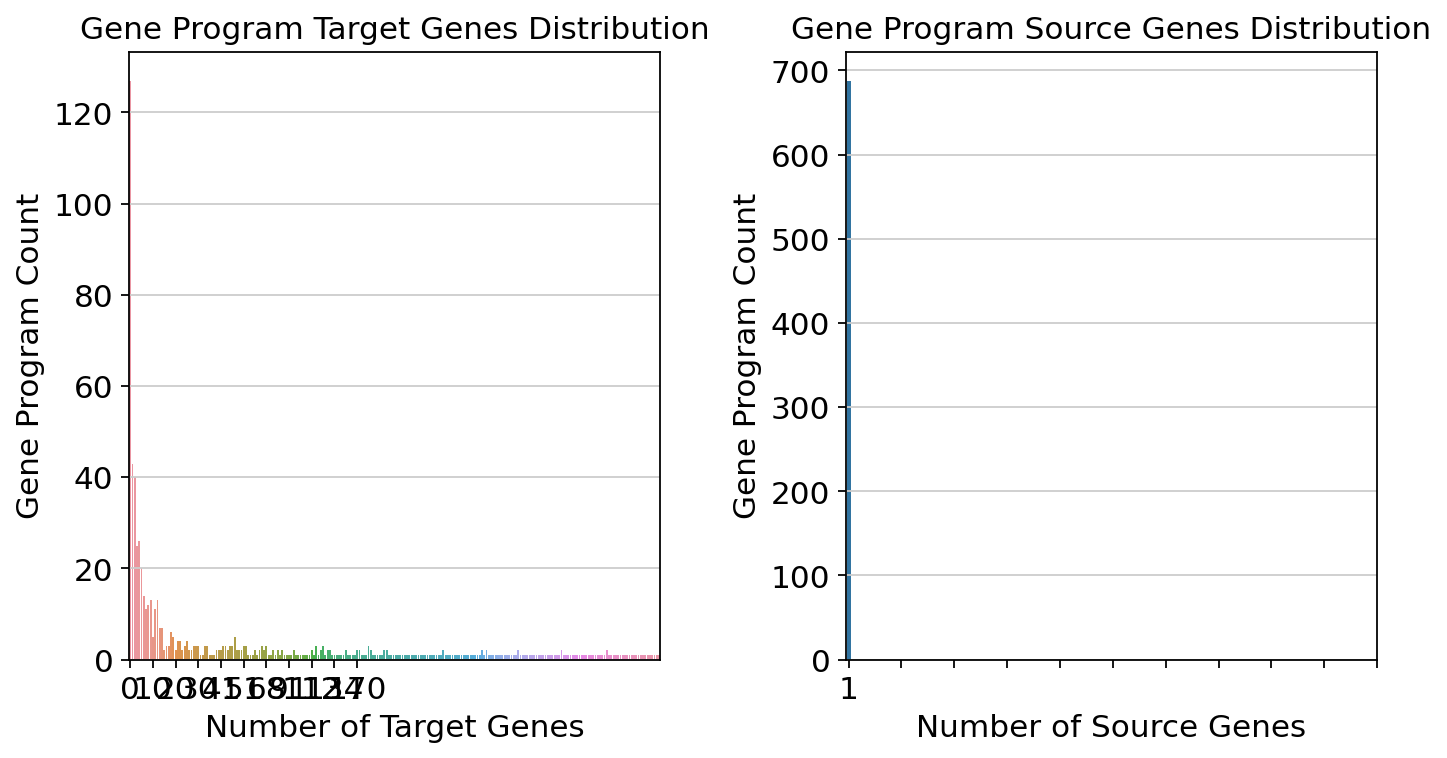

In [8]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=20000,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=True)

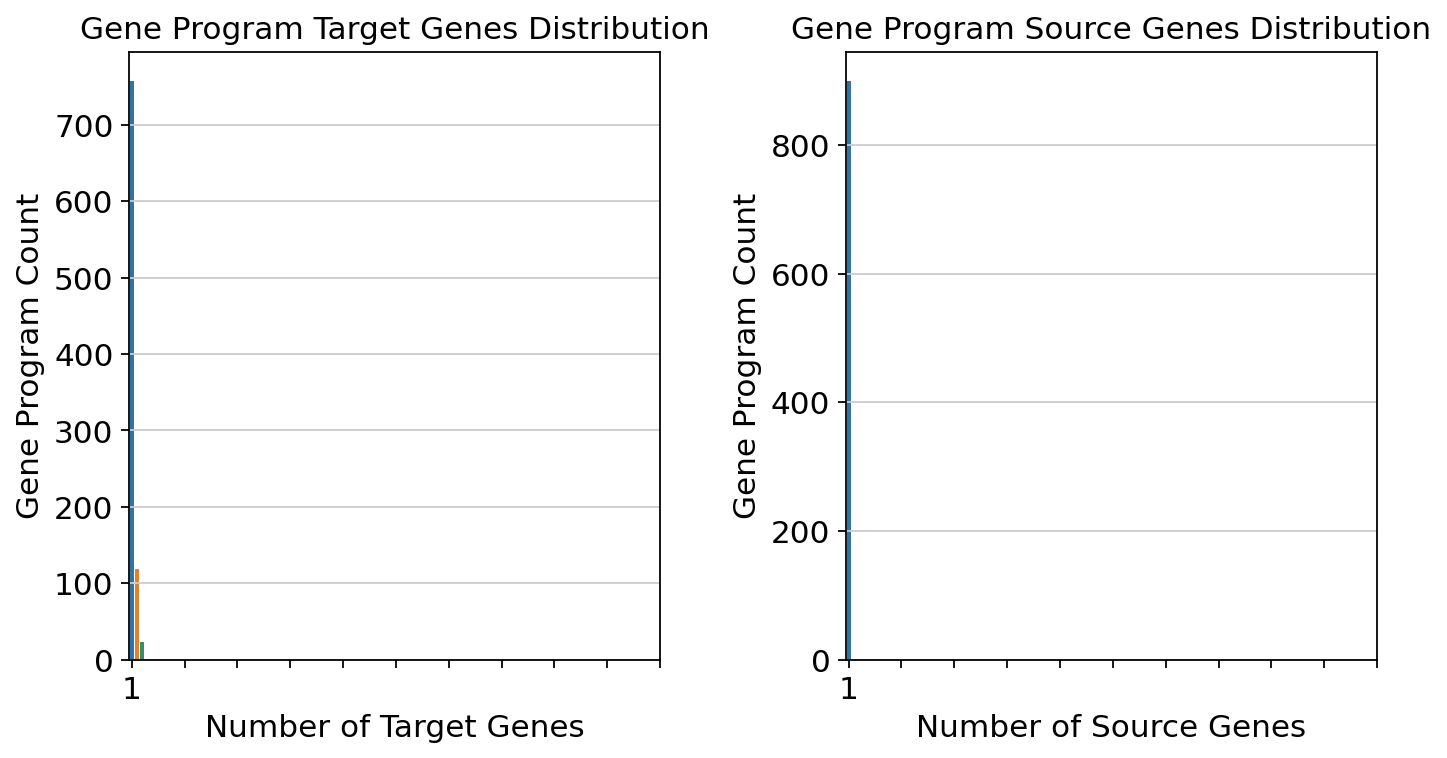

In [9]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=True)

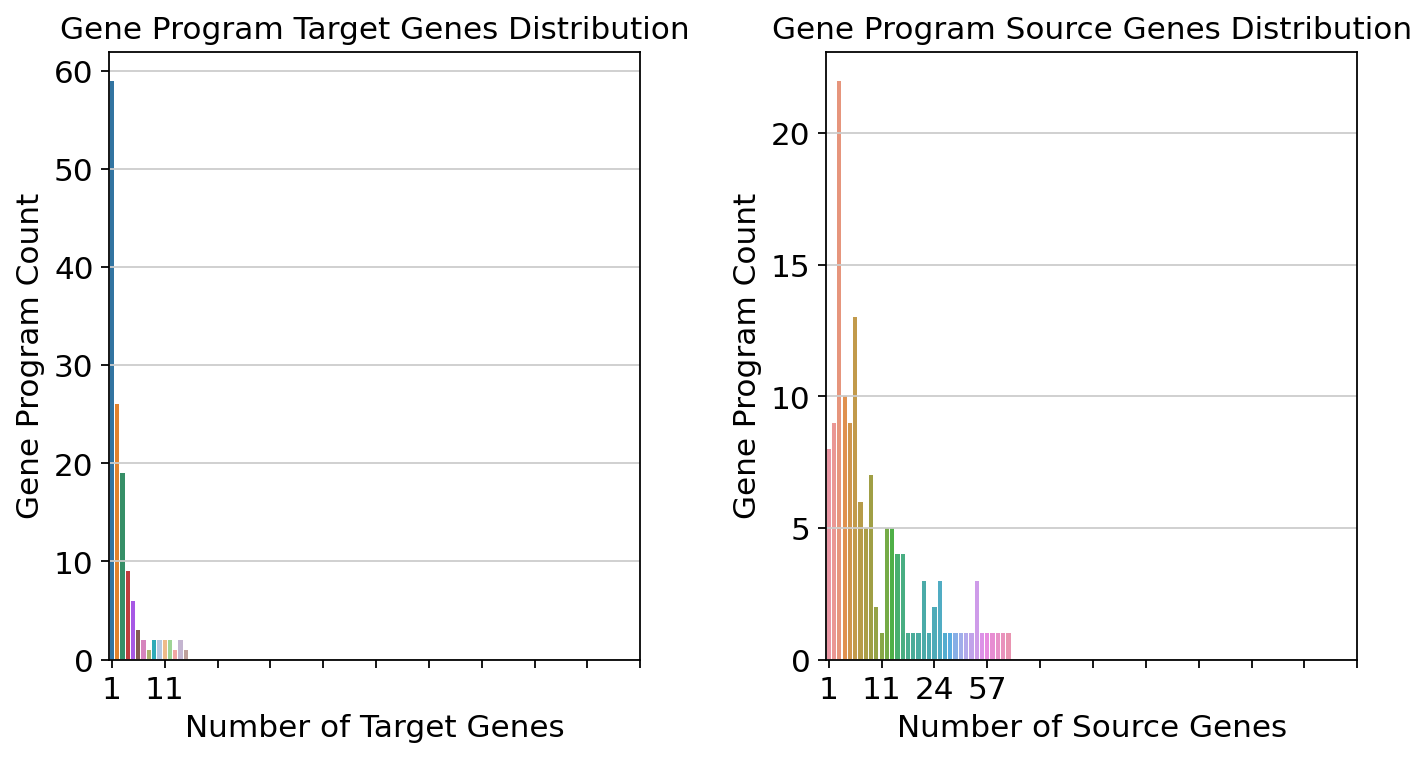

In [10]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True,
    plot_gp_gene_count_distributions=True)

In [11]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [12]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset", #None,
    combine_overlap_gps=True, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

### 2.2 Define Training Function

In [13]:
def train_expimap_models(dataset,
                         cell_type_key,
                         adata_new=None,
                         n_start_run=1,
                         n_end_run=10,
                         n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                         plot_latent_umaps: bool=False):
    
    # Configure figure folder path
    dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/method_benchmarking/expimap/{current_timestamp}"
    os.makedirs(dataset_figure_folder_path, exist_ok=True)
    
    # Create new adata to store results from training runs in storage-efficient way
    if adata_new is None:
        adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        adata_new = sc.AnnData(sp.csr_matrix(
            (adata_original.shape[0], adata_original.shape[1]),
            dtype=np.float32))
        adata_new.obs["cell_type"] = adata_original.obs[cell_type_key].values
        del(adata_original)
    
    model_seeds = list(range(10))
    for run_number, n_neighbors in zip(np.arange(n_start_run, n_end_run+1), n_neighbor_list):
        # n_neighbors is here only used for the latent neighbor graph construction used for
        # UMAP generation and clustering as expiMap is not a spatial method
        
        # Load data
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        # Store raw counts in optimized format in adata.X
        adata.layers["counts"] = adata.layers["counts"].tocsr()
        adata.X = adata.layers["counts"]
        
        adata.obs["batch"] == "batch1"  
        
        # Add the gene program dictionary as binary masks to the adata for model training
        # Use only target genes from the Autotalker gene program mask
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="I",
            gp_sources_mask_key="_",
            gp_names_key="terms",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        # Determine dimensionality of hidden encoder
        n_hidden_encoder = len(adata.uns["terms"])
        
        start_time = time.time()
        
        # Initialize model
        intr_cvae = sca.models.EXPIMAP(adata=adata,
                                       condition_key="batch",
                                       hidden_layer_sizes=[256, 256, 256],
                                       recon_loss="nb")

        # Train model
        early_stopping_kwargs = {
            "early_stopping_metric": "val_unweighted_loss",
            "threshold": 0,
            "patience": 50,
            "reduce_lr": True,
            "lr_patience": 13,
            "lr_factor": 0.1}
        intr_cvae.train(
            n_epochs=400,
            alpha_epoch_anneal=100,
            alpha=0.7,
            alpha_kl=0.5,
            weight_decay=0.,
            early_stopping_kwargs=early_stopping_kwargs,
            use_early_stopping=True,
            monitor_only_val=False,
            seed=model_seeds[run_number-1])

        # Store latent representation
        adata.obsm[latent_key] = intr_cvae.get_latent(mean=False, only_active=True)
        
        # Measure time for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Duration of model training in run {run_number}: {int(hours)} hours, {int(minutes)} minutes and {int(seconds)} seconds.")
        adata_new.uns[f"{model_name}_model_training_duration_run{run_number}"] = (
            elapsed_time)

        if plot_latent_umaps:
            # Use expiMap latent space for UMAP generation
            sc.pp.neighbors(adata,
                            use_rep=latent_key,
                            n_neighbors=n_neighbors)
            sc.tl.umap(adata)
            fig = sc.pl.umap(adata,
                             color=[cell_type_key],
                             title="Latent Space with Cell Types: expiMap",
                             return_fig=True)
            fig.savefig(f"{dataset_figure_folder_path}/latent_{model_name}"
                        f"_cell_types_run{run_number}.png",
                        bbox_inches="tight")

            # Compute latent Leiden clustering
            sc.tl.leiden(adata=adata,
                         resolution=leiden_resolution,
                         random_state=random_seed,
                         key_added=f"latent_{model_name}_leiden_{str(leiden_resolution)}")

            # Create subplot of latent Leiden cluster annotations in physical and latent space
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
            title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: expiMap")
            sc.pl.umap(adata=adata,
                       color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                       title=f"Latent Space with Leiden Clusters",
                       ax=axs[0],
                       show=False)
            sq.pl.spatial_scatter(adata=adata,
                                  color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                                  title=f"Physical Space with Leiden Clusters",
                                  shape=None,
                                  ax=axs[1])

            # Create and position shared legend
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()

            # Adjust, save and display plot
            plt.subplots_adjust(wspace=0, hspace=0.2)
            fig.savefig(f"{dataset_figure_folder_path}/latent_physical_comparison_"
                        f"{model_name}_run{run_number}.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.show()

        # Store latent representation
        adata_new.obsm[latent_key + f"_run{run_number}"] = adata.obsm[latent_key]

        # Store intermediate adata to disk
        adata_new.write(f"{data_folder_path}/{dataset}_{model_name}.h5ad")

    # Store final adata to disk
    adata_new.write(f"{data_folder_path}/{dataset}_{model_name}.h5ad")    

### 2.3 Train Models on Benchmarking Datasets

In [ ]:
train_expimap_models(dataset="seqfish_mouse_organogenesis_embryo2",
                     cell_type_key="celltype_mapped_refined",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
train_expimap_models(dataset="vizgen_merfish_mouse_liver",
                     cell_type_key="Cell_Type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
# ~10% sample of the original dataset
train_expimap_models(dataset="vizgen_merfish_mouse_liver_sample",
                     cell_type_key="Cell_Type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 347 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 522
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  522 0 0 1 347
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |███████-------------| 35.2%  - epoch_loss: 348.5364542486 - epoch_recon_loss: 330.7999005999 - epoch_kl_loss: 35.4731088439 - val_loss: 348.4906868770 - val_recon_loss: 330.8153749663 - val_kl_loss: 35.3506180336292
ADJUSTED LR
 |████████------------| 44.0%  - epoch_loss: 348.3896692931 - epoch_recon_loss: 330.3808236730 - epoch_kl_loss: 36.0176925659 - val_loss: 347.7467619797 - val_recon_loss: 330.2693176270 - val_kl_loss: 34.9548866009
ADJUSTED LR
 |█████████-----------| 47.8%  - epoch_loss: 348.3118261389 - epoch_recon_loss: 330.3210706085 - epoch_kl_loss: 35.9815110608 - val_loss: 347.5412934402 - 

In [ ]:
train_expimap_models(dataset="starmap_plus_mouse_cns",
                     cell_type_key="Main_molecular_cell_type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
# ~20% sample of the original dataset
train_expimap_models(dataset="starmap_plus_mouse_cns_sample",
                     cell_type_key="Main_molecular_cell_type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
train_expimap_models(dataset="nanostring_cosmx_human_nsclc",
                     cell_type_key="cell_type",
                     adata_new=adata_new,
                     n_start_run=2,
                     n_end_run=10,
                     n_neighbor_list=[4, 8, 8, 12, 12, 16, 16, 20, 20])

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 33.2%  - epoch_loss: 414.1964155444 - epoch_recon_loss: 400.0102633003 - epoch_kl_loss: 28.3723055100 - val_loss: 409.9274869977 - val_recon_loss: 396.3171752005 - val_kl_loss: 27.2206238255232
ADJUSTED LR
 |███████-------------| 37.8%  - epoch_loss: 414.2932335990 - epoch_recon_loss: 400.0447728164 - epoch_kl_loss: 28.4969219415 - val_loss: 409.3431567568 - val_recon_loss: 395.6719910593 - val_kl_loss: 27.3423338225
ADJUSTED LR
 |████████------------| 41.0%  - epoch_loss: 413.6262759254 - epoch_recon_loss: 399.3838884522 - epoch_kl_loss: 28.4847755789 - val_loss: 409.9245688699 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 33.2%  - epoch_loss: 416.0952547553 - epoch_recon_loss: 401.8778007663 - epoch_kl_loss: 28.4349083803 - val_loss: 410.3441277706 - val_recon_loss: 396.8173060562 - val_kl_loss: 27.0536430821180
ADJUSTED LR
 |███████-------------| 37.0%  - epoch_loss: 415.0635509880 - epoch_recon_loss: 400.7876620130 - epoch_kl_loss: 28.5517776256 - val_loss: 410.1410462351 - val_recon_loss: 396.3753144235 - val_kl_loss: 27.5314631607
ADJUSTED LR
 |████████------------| 40.2%  - epoch_loss: 413.9210276701 - epoch_recon_loss: 399.6714070119 - epoch_kl_loss: 28.4992396458 - val_loss: 409.8042103161 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 33.2%  - epoch_loss: 413.7890609949 - epoch_recon_loss: 399.6603129380 - epoch_kl_loss: 28.2574951827 - val_loss: 409.3245105165 - val_recon_loss: 395.4968506784 - val_kl_loss: 27.6553194740808
ADJUSTED LR
 |████████------------| 43.8%  - epoch_loss: 414.6849662625 - epoch_recon_loss: 400.4579090456 - epoch_kl_loss: 28.4541147550 - val_loss: 409.9173893784 - val_recon_loss: 396.1342731823 - val_kl_loss: 27.5662290400
ADJUSTED LR
 |█████████-----------| 47.0%  - epoch_loss: 413.8626181155 - epoch_recon_loss: 399.6645632893 - epoch_kl_loss: 28.3961102200 - val_loss: 409.8811543783 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 31.0%  - epoch_loss: 413.2036457711 - epoch_recon_loss: 398.8311392855 - epoch_kl_loss: 28.7450123028 - val_loss: 414.9884490967 - val_recon_loss: 401.0283610026 - val_kl_loss: 27.9201778065301
ADJUSTED LR
 |██████--------------| 34.2%  - epoch_loss: 413.7056710379 - epoch_recon_loss: 399.2427450686 - epoch_kl_loss: 28.9258518706 - val_loss: 414.6559055213 - val_recon_loss: 400.5984589548 - val_kl_loss: 28.1148940000
ADJUSTED LR
 |████████------------| 40.8%  - epoch_loss: 413.7088940679 - epoch_recon_loss: 399.2342603515 - epoch_kl_loss: 28.9492673906 - val_loss: 414.7705739339 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 34.2%  - epoch_loss: 413.9674892815 - epoch_recon_loss: 399.6208486233 - epoch_kl_loss: 28.6932808623 - val_loss: 415.0985666911 - val_recon_loss: 401.0093675093 - val_kl_loss: 28.1783942598314
ADJUSTED LR
 |███████-------------| 39.8%  - epoch_loss: 414.1331339726 - epoch_recon_loss: 399.6830736537 - epoch_kl_loss: 28.9001203978 - val_loss: 414.5761801980 - val_recon_loss: 400.6960661917 - val_kl_loss: 27.7602268277
ADJUSTED LR
 |████████------------| 43.0%  - epoch_loss: 413.8846437104 - epoch_recon_loss: 399.4546226969 - epoch_kl_loss: 28.8600412680 - val_loss: 414.8242945816 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 30.2%  - epoch_loss: 412.8248073033 - epoch_recon_loss: 398.6178905980 - epoch_kl_loss: 28.4138339231 - val_loss: 416.9026812929 - val_recon_loss: 403.0892033432 - val_kl_loss: 27.6269547434646
ADJUSTED LR
 |███████-------------| 38.5%  - epoch_loss: 412.3524754323 - epoch_recon_loss: 398.0826352178 - epoch_kl_loss: 28.5396798062 - val_loss: 416.6165919448 - val_recon_loss: 402.7029488303 - val_kl_loss: 27.8272860845
ADJUSTED LR
 |████████------------| 41.8%  - epoch_loss: 413.4392468199 - epoch_recon_loss: 399.1233992285 - epoch_kl_loss: 28.6316947418 - val_loss: 417.4908433394 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 33.5%  - epoch_loss: 414.9827915114 - epoch_recon_loss: 401.0405597298 - epoch_kl_loss: 27.8844631545 - val_loss: 413.9061968254 - val_recon_loss: 400.0706329346 - val_kl_loss: 27.6711250074638
ADJUSTED LR
 |███████-------------| 36.8%  - epoch_loss: 413.7094205999 - epoch_recon_loss: 399.6856053151 - epoch_kl_loss: 28.0476309491 - val_loss: 413.3413770271 - val_recon_loss: 399.7288295861 - val_kl_loss: 27.2250962691
ADJUSTED LR
 |████████------------| 40.0%  - epoch_loss: 413.7346337766 - epoch_recon_loss: 399.7471611905 - epoch_kl_loss: 27.9749443937 - val_loss: 413.5457287413 

In [ ]:
train_expimap_models(dataset="nanostring_cosmx_human_nsclc",
                     cell_type_key="cell_type",
                     adata_new=None,
                     n_start_run=1,
                     n_end_run=10,
                     n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |██████--------------| 34.8%  - epoch_loss: 413.9096278496 - epoch_recon_loss: 399.5175521228 - epoch_kl_loss: 28.7841515184 - val_loss: 416.4867562959 - val_recon_loss: 402.4342128869 - val_kl_loss: 28.1050882917865
ADJUSTED LR
 |███████-------------| 38.0%  - epoch_loss: 414.7473202141 - epoch_recon_loss: 400.2648802258 - epoch_kl_loss: 28.9648811152 - val_loss: 416.0681642475 - val_recon_loss: 402.0117025664 - val_kl_loss: 28.1129184492
ADJUSTED LR
 |████████------------| 41.2%  - epoch_loss: 413.6428977811 - epoch_recon_loss: 399.1854216387 - epoch_kl_loss: 28.9149515742 - val_loss: 415.7063862194 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 960 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 1055
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  1055 0 0 1 960
	with hard mask.
Last Decoder layer: softmax
Init the group lasso proximal operator for the main terms.
 |--------------------| 4.0%  - epoch_loss: 396.1698900599 - epoch_recon_loss: 388.0826828626 - epoch_kl_loss: 107.8294320139 - val_loss: 393.6032603871 - val_recon_loss: 385.8349424420 - val_kl_loss: 103.577565973594